In [114]:
import numpy as np
import pandas as pd

#!pip install soynlp
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

import os
import shutil

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import (
    Embedding,
    Flatten,
    GRU,
    Conv1D,
    Lambda,
    Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


print(tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

LOGDIR = "./text_models"

2.12.0


In [115]:
data = pd.read_csv('review_dataset.csv',encoding='utf-8')
print(data.head())
#print(data['content'])
data['content'] = data['content'].apply(str)

                                             content  메뉴명
0  아이스 아메리카노는 단맛이나 크림 등이 없어서 맛이 진하다. 내 취향에 딱 맞아서 좋다.    0
1  아이스 아메리카노는 맛이 너무 진해서 좀 까다로운 편인데, 이곳은 정말 괜찮은 편이...    0
2  커피를 그다지 좋아하지 않는데, 이 아이스 아메리카노는 내가 시도한 커피 중에 제일...    0
3  아이스 아메리카노가 별로 맛이 없어서 실망했다. 커피 취향이 있는 사람들은 이곳에서...    0
4  저는 아이스 아메리카노에 누구보다도 예민한 편인데, 이곳에서는 항상 맛있게 마시고 ...    0


In [116]:
#!pip install -U pandas-profiling
corpus = data.content.apply(str)
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score = word_extractor.extract()
scores = {word:score.cohesion_forward for word, score in word_score.items()}
maxscore_tokenizer = MaxScoreTokenizer(scores=scores)

def soynlp_morphs(contents):
    return ' '.join(maxscore_tokenizer.tokenize(contents))

training was done. used memory 0.657 Gb
all cohesion probabilities was computed. # words = 910
all branching entropies was computed # words = 1703
all accessor variety was computed # words = 1703


In [117]:
%%time
data['soynlp_morphs_contents'] = data['content'].apply(soynlp_morphs)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 145 ms


In [118]:
X = data.soynlp_morphs_contents
y = data.메뉴명

In [119]:
## X,y
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)  ### vovab을 만들고 각 단어마다 고유번호를 매긴 후 번호를 순서에 따라 매핑하는 방법

In [120]:
word_to_index = tokenizer.word_index
VOCAB_SIZE = len(word_to_index) + 1  ##  padding 할때 필요한 0 index 추가

In [121]:
MAX_LEN = max(len(seq) for seq in sequences)
print(MAX_LEN)

79


In [122]:
def encode_labels(sources):
    classes = [source for source in sources]
    #print(classes)
    one_hots = to_categorical(classes)
    #print(one_hots)
    return one_hots

In [127]:
def create_sequences(texts, max_len=MAX_LEN):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, max_len, padding='post')
    return padded_sequences

In [128]:
#print(y)
X_train, X_test, y_train, y_test = train_test_split(create_sequences(X), encode_labels(y), test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
#종속 변수의 클래스 수
N_CLASSES =4

In [129]:
def build_dnn_model(embed_dim):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN]), 
        Lambda(lambda x: tf.reduce_mean(x, axis=1)), 
        Dense(100, activation='relu'),
        Dense(100, activation='relu'),
        Dense(N_CLASSES, activation='softmax')  ## activation=tf.nn.softmax
    ])

    model.compile(
        # optimizer=tf.keras.optimizers.Adam(
        #     learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        #     name='Adam'
        # )
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.3858 - accuracy: 0.2423 - val_loss: 1.3850 - val_accuracy: 0.2759
Epoch 2/50
1/1 [==============================] - 0s 63ms/step - loss: 1.3844 - accuracy: 0.2423 - val_loss: 1.3840 - val_accuracy: 0.3103
Epoch 3/50
1/1 [==============================] - 0s 69ms/step - loss: 1.3831 - accuracy: 0.2923 - val_loss: 1.3831 - val_accuracy: 0.5862
Epoch 4/50
1/1 [==============================] - 0s 58ms/step - loss: 1.3820 - accuracy: 0.6423 - val_loss: 1.3821 - val_accuracy: 0.5862
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 1.3808 - accuracy: 0.6538 - val_loss: 1.3812 - val_accuracy: 0.4138
Epoch 6/50
1/1 [==============================] - 0s 62ms/step - loss: 1.3797 - accuracy: 0.5038 - val_loss: 1.3804 - val_accuracy: 0.2414
Epoch 7/50
1/1 [==============================] - 0s 53ms/step - loss: 1.3785 - accuracy: 0.4192 - val_loss: 1.3795 - val_accuracy: 0.2414
Epoch 8/50
1/1 [=============

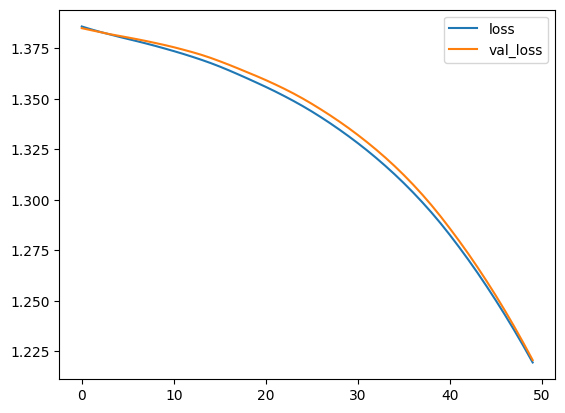

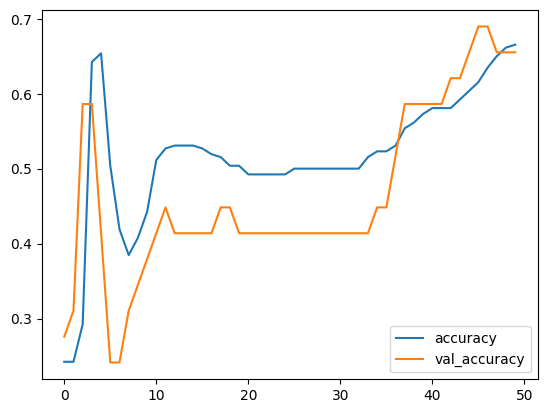

In [131]:
%%time
tf.random.set_seed(33) # tf 2.0에서 적용

MODEL_DIR = os.path.join(LOGDIR, 'dnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

BATCH_SIZE = 300  #300
EPOCHS = 50 #50
EMBED_DIM = 100
PATIENCE = 0

dnn_model = build_dnn_model(embed_dim=EMBED_DIM)

dnn_history = dnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

## tf 2.0 : 'accuracy', 'val_accuracy','loss', 'val_loss'
pd.DataFrame(dnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(dnn_history.history)[['accuracy', 'val_accuracy']].plot()

dnn_model.summary()

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.3849 - accuracy: 0.2192 - val_loss: 1.3665 - val_accuracy: 0.4828
Epoch 2/50
1/1 [==============================] - 0s 123ms/step - loss: 1.3542 - accuracy: 0.5115 - val_loss: 1.3480 - val_accuracy: 0.4483
Epoch 3/50
1/1 [==============================] - 0s 176ms/step - loss: 1.3258 - accuracy: 0.5615 - val_loss: 1.3284 - val_accuracy: 0.4483
Epoch 4/50
1/1 [==============================] - 0s 238ms/step - loss: 1.2971 - accuracy: 0.5538 - val_loss: 1.3037 - val_accuracy: 0.4828
Epoch 5/50
1/1 [==============================] - 0s 258ms/step - loss: 1.2659 - accuracy: 0.5731 - val_loss: 1.2730 - val_accuracy: 0.5172
Epoch 6/50
1/1 [==============================] - 0s 238ms/step - loss: 1.2309 - accuracy: 0.6385 - val_loss: 1.2367 - val_accuracy: 0.5862
Epoch 7/50
1/1 [==============================] - 0s 220ms/step - loss: 1.1917 - accuracy: 0.6577 - val_loss: 1.1950 - val_accuracy: 0.6207
Epoch 8/50
1/1 [=======

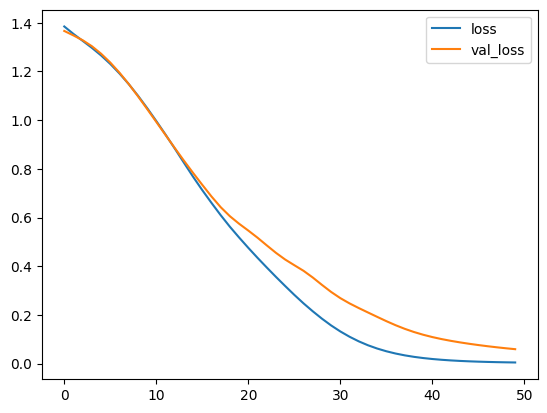

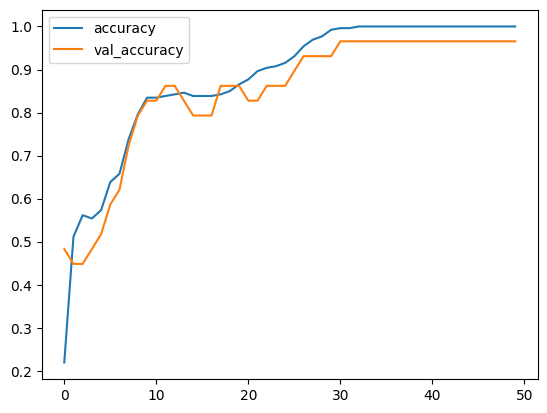

In [139]:
#RNN

def build_rnn_model(embed_dim, units):

    model = Sequential([
        Embedding(VOCAB_SIZE + 1, embed_dim, input_shape=[MAX_LEN], mask_zero=True), 
        GRU(units), 
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 1.3854 - accuracy: 0.3154 - val_loss: 1.3826 - val_accuracy: 0.2759
Epoch 2/50
1/1 [==============================] - 0s 151ms/step - loss: 1.3770 - accuracy: 0.3654 - val_loss: 1.3765 - val_accuracy: 0.4138
Epoch 3/50
1/1 [==============================] - 0s 195ms/step - loss: 1.3687 - accuracy: 0.4538 - val_loss: 1.3704 - val_accuracy: 0.4138
Epoch 4/50
1/1 [==============================] - 0s 148ms/step - loss: 1.3602 - accuracy: 0.5000 - val_loss: 1.3642 - val_accuracy: 0.5517
Epoch 5/50
1/1 [==============================] - 0s 154ms/step - loss: 1.3517 - accuracy: 0.6385 - val_loss: 1.3579 - val_accuracy: 0.5517
Epoch 6/50
1/1 [==============================] - 0s 139ms/step - loss: 1.3431 - accuracy: 0.6615 - val_loss: 1.3515 - val_accuracy: 0.5517
Epoch 7/50
1/1 [==============================] - 0s 142ms/step - loss: 1.3343 - accuracy: 0.6808 - val_loss: 1.3449 - val_accuracy: 0.5172
Epoch 8/50
1/1 [=======

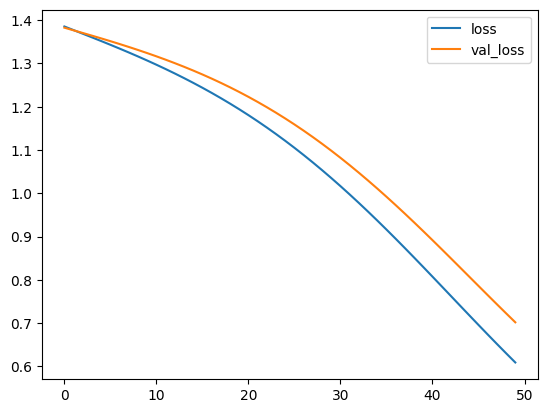

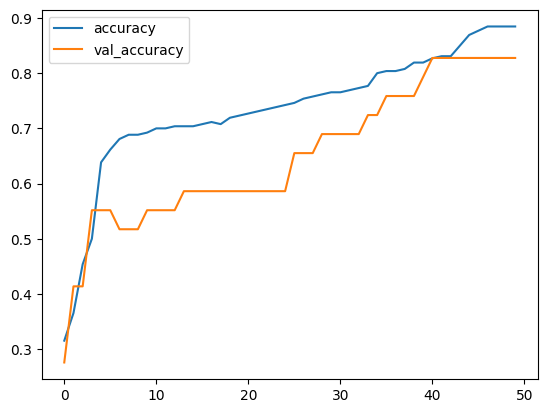

In [141]:
%%time

tf.random.set_seed(33)

MODEL_DIR = os.path.join(LOGDIR, 'rnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 50
BATCH_SIZE = 300
EMBED_DIM = 100
UNITS = 16
PATIENCE = 0

rnn_model = build_rnn_model(embed_dim=EMBED_DIM, units=UNITS)

history = rnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
    use_multiprocessing=True ## OOM error out of memory error가 발생할때 True로 변경하여 준다 
)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

rnn_model.summary()

In [142]:
#CNN

def build_cnn_model(embed_dim, filters, ksize, strides):

    model = Sequential([
        Embedding(
            VOCAB_SIZE + 1,
            embed_dim,
            input_shape=[MAX_LEN],
            mask_zero=True),
        Conv1D( 
            filters=filters,
            kernel_size=ksize,
            strides=strides,
            activation='relu',
        ),
        Flatten(), 
        Dense(N_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 1.3897 - accuracy: 0.2769 - val_loss: 1.3653 - val_accuracy: 0.2759
Epoch 2/50
1/1 [==============================] - 0s 146ms/step - loss: 1.3552 - accuracy: 0.2962 - val_loss: 1.3469 - val_accuracy: 0.4138
Epoch 3/50
1/1 [==============================] - 0s 139ms/step - loss: 1.3245 - accuracy: 0.5308 - val_loss: 1.3281 - val_accuracy: 0.4483
Epoch 4/50
1/1 [==============================] - 0s 138ms/step - loss: 1.2945 - accuracy: 0.5500 - val_loss: 1.3055 - val_accuracy: 0.4138
Epoch 5/50
1/1 [==============================] - 0s 148ms/step - loss: 1.2631 - accuracy: 0.5423 - val_loss: 1.2760 - val_accuracy: 0.4828
Epoch 6/50
1/1 [==============================] - 0s 135ms/step - loss: 1.2279 - accuracy: 0.5846 - val_loss: 1.2395 - val_accuracy: 0.5517
Epoch 7/50
1/1 [==============================] - 0s 135ms/step - loss: 1.1882 - accuracy: 0.6346 - val_loss: 1.1964 - val_accuracy: 0.5862
Epoch 8/50
1/1 [=======

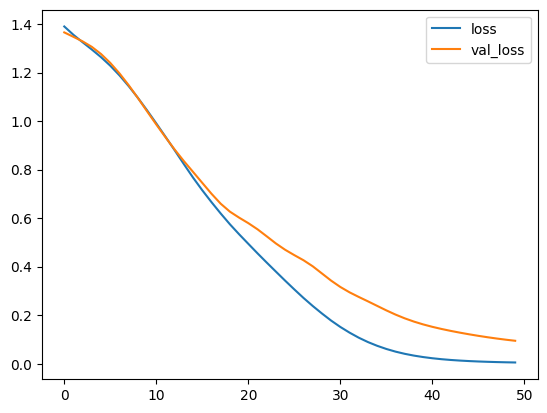

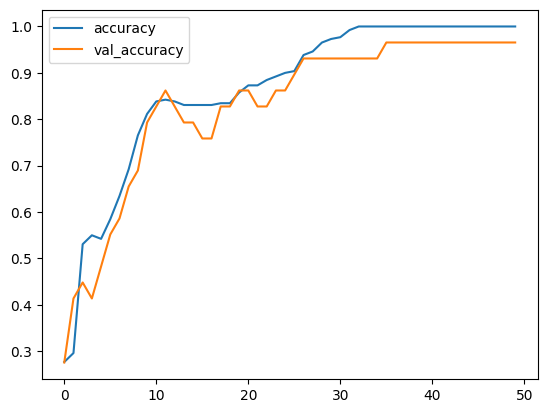

In [143]:
%%time

tf.random.set_seed(33) 

MODEL_DIR = os.path.join(LOGDIR, 'cnn')
shutil.rmtree(MODEL_DIR, ignore_errors=True)

EPOCHS = 50
BATCH_SIZE = 300
EMBED_DIM = 100
FILTERS = 200
STRIDES = 2
KSIZE = 3
PATIENCE = 0


cnn_model = build_cnn_model(
    embed_dim=EMBED_DIM,
    filters=FILTERS,
    strides=STRIDES,
    ksize=KSIZE,
)

cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(patience=PATIENCE), TensorBoard(MODEL_DIR)],
)

pd.DataFrame(cnn_history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(cnn_history.history)[['accuracy', 'val_accuracy']].plot()

cnn_model.summary()

In [205]:
def convert_argmax(array):
    return np.argmax(array, axis=1)

menu = {0:"아이스 아메리카노", 1: "따뜻한 아메리카노", 2: "콜드브루", 3: "카라멜마끼아또"}

In [206]:
test = ["시원한", "카라멜", "따뜻한", "시원한 음료"]

In [207]:
print("***********************DNN******************************")
x_text = create_sequences(test)
result = dnn_model.predict(x_text)
#print(result)
#print(convert_argmax(result))
for i in convert_argmax(result):
  print(menu[i])


***********************DNN******************************
1/1 [==============================] - 0s 34ms/step
콜드브루
콜드브루
콜드브루
콜드브루


In [208]:
print("***********************CNN******************************")
x_text = create_sequences(test)
result = cnn_model.predict(x_text)
#print(result)
#print(convert_argmax(result))
for i in convert_argmax(result):
  print(menu[i])

***********************CNN******************************
1/1 [==============================] - 0s 24ms/step
아이스 아메리카노
아이스 아메리카노
아이스 아메리카노
아이스 아메리카노


In [209]:
print("***********************RNN******************************")
x_text = create_sequences(test)
result = rnn_model.predict(x_text)
#print(result)
#print(convert_argmax(result))
for i in convert_argmax(result):
  print(menu[i])

***********************RNN******************************
1/1 [==============================] - 0s 46ms/step
콜드브루
카라멜마끼아또
따뜻한 아메리카노
카라멜마끼아또
